# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [102]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

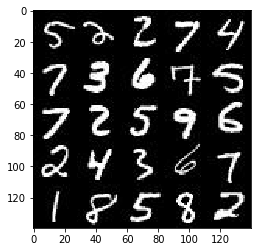

In [103]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

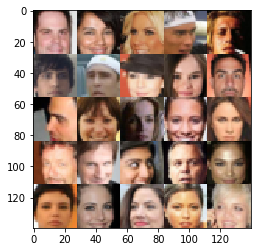

In [104]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [105]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/home/ahmed/Dropbox/udacity_dlfnp/venv/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [106]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs = tf.placeholder(dtype=tf.float32,shape=[None,image_width,image_height,image_channels], name='inputs')
    z_data = tf.placeholder(dtype=tf.float32,shape=[None,z_dim], name='z_data')
    learning_rate = tf.placeholder(dtype=tf.float32, shape=(), name='learning_rate')
    return inputs, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [107]:
def conv_unit(input,filters,alpha,batch_norm_bool):
    conv = tf.layers.conv2d(inputs=input, 
                             filters= filters, 
                             kernel_size=(5,5), 
                             strides=(2,2), 
                             padding='same')
    if batch_norm_bool:
        conv = tf.layers.batch_normalization(inputs=conv, training=True)
    conv = tf.maximum(alpha*conv,conv)
    return conv

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = conv_unit(images, 64, alpha, False)
        conv2 = conv_unit(conv1, 128, alpha, True)
        conv3 = conv_unit(conv2, 256, alpha, True)
        shape = conv3.get_shape().as_list()  
        shape = shape[1]*shape[2]*shape[3]
        flat = tf.reshape(tensor=conv3, shape=(-1,shape))
        logits = tf.layers.dense(inputs=flat, units=1)
        output = tf.nn.sigmoid(logits)
#         print (conv1.get_shape())
#         print (conv2.get_shape())
#         print (conv3.get_shape())

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [108]:
def trans_conv_unit(input,filters,padding,alpha,training):
    trans_conv = tf.layers.conv2d_transpose(inputs=input, 
                             filters= filters, 
                             kernel_size=(5,5), 
                             strides=(2,2), 
                             padding=padding)
    trans_conv = tf.layers.batch_normalization(inputs=trans_conv, training=training)
    trans_conv = tf.maximum(alpha*trans_conv,trans_conv)
    return trans_conv


def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    with tf.variable_scope('generator', reuse=not is_train):
        fc = tf.layers.dense(inputs=z, units=2*2*512 )
        fc = tf.reshape(tensor=fc, shape=[-1,2,2,512])
        fc = tf.layers.batch_normalization(inputs=fc, training=is_train)
        fc = tf.maximum(alpha*fc,fc)
        #
        trans_conv1 = trans_conv_unit(fc,256,'valid',alpha,is_train)
        #
        trans_conv2 = trans_conv_unit(trans_conv1,128,'same',alpha,is_train)
        #
        trans_conv3 = tf.layers.conv2d_transpose(inputs=trans_conv2, 
                                 filters= out_channel_dim, 
                                 kernel_size=(5,5), 
                                 strides=(2,2), 
                                 padding='same')
#         print (fc.get_shape())
#         print (trans_conv1.get_shape())
#         print (trans_conv2.get_shape())
#         print (trans_conv3.get_shape())   
        #
        output = tf.nn.tanh(x=trans_conv3)
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [109]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # 
    output_generator = generator(input_z, out_channel_dim, is_train=True)
    output_discriminator_real, logits_discriminator_real = discriminator(input_real, reuse=False)
    output_discriminator_fake, logits_discriminator_fake = discriminator(output_generator, reuse=True)
    #
    loss_discriminator_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(output_discriminator_real),
                                                        logits=logits_discriminator_real))
    loss_discriminator_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(output_discriminator_real),
                                                        logits=logits_discriminator_fake))    
    loss_generator = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(output_discriminator_real),
                                                        logits=logits_discriminator_fake))
    loss_discriminator = loss_discriminator_real + loss_discriminator_fake
    return loss_discriminator, loss_generator


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [110]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    all_vars = tf.trainable_variables()
    g_vars = [var for var in all_vars if var.name.startswith('generator')]
    d_vars = [var for var in all_vars if var.name.startswith('discriminator')]
    
    d_op = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss,var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_op = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_op, g_op




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [111]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [126]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    image_channels = 1
    if data_image_mode=="RGB":
        image_channels = 3
    # placeholder
    inputs, z_data, lr = model_inputs(data_shape[1], data_shape[2], image_channels, z_dim)
    # loss/cost
    loss_discriminator, loss_generator = model_loss(inputs, z_data, image_channels)
    # optimizer
    d_op, g_op = model_opt(loss_discriminator, loss_generator, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for idx, batch_images in enumerate(get_batches(batch_size)):
                # fix batch images
                batch_images *= 2.0
                
                # z vector
                z = np.random.uniform(low=-1, high=1, size=(batch_size,z_dim)).astype(np.float32)
                _  = sess.run(fetches=[d_op], feed_dict={inputs:batch_images, 
                                                          z_data:z, 
                                                          lr:learning_rate})
                _  = sess.run(fetches=[g_op], feed_dict={inputs:batch_images,
                                                         z_data:z, 
                                                          lr:learning_rate})
                # every 20 batches
                if idx%20 == 0:
                    # At the end of each epoch, get the losses and print them out
                    loss_d = loss_discriminator.eval({inputs: batch_images, 
                                          z_data: z})
                    loss_g = loss_generator.eval({inputs: batch_images, 
                                          z_data: z})

                    print("epoch {} batch {}".format(epoch_i, idx),
                          "Discriminator Loss: {:.4f}".format(loss_d),
                          "Generator Loss: {:.4f}".format(loss_g))
                
                
                # every 100 batches
                if idx%100==0:
                    show_generator_output(sess, 20, z_data, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

epoch 0 batch 0 Discriminator Loss: 29.3896 Generator Loss: 0.0000


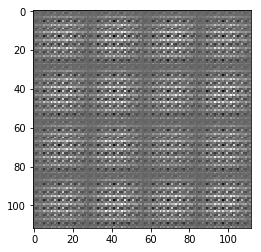

epoch 0 batch 20 Discriminator Loss: 0.4791 Generator Loss: 1.0422
epoch 0 batch 40 Discriminator Loss: 0.0004 Generator Loss: 9.3114
epoch 0 batch 60 Discriminator Loss: 0.0252 Generator Loss: 6.3477
epoch 0 batch 80 Discriminator Loss: 0.5267 Generator Loss: 2.1030
epoch 0 batch 100 Discriminator Loss: 0.8916 Generator Loss: 0.9718


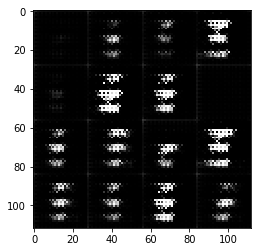

epoch 0 batch 120 Discriminator Loss: 0.2714 Generator Loss: 2.2721
epoch 0 batch 140 Discriminator Loss: 0.8942 Generator Loss: 11.5869
epoch 0 batch 160 Discriminator Loss: 0.7446 Generator Loss: 1.0363
epoch 0 batch 180 Discriminator Loss: 0.2252 Generator Loss: 3.3526
epoch 0 batch 200 Discriminator Loss: 0.1882 Generator Loss: 5.6202


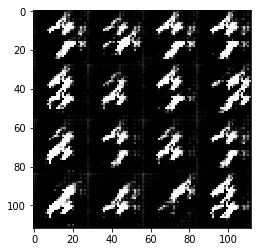

epoch 0 batch 220 Discriminator Loss: 0.1121 Generator Loss: 2.9851
epoch 0 batch 240 Discriminator Loss: 0.2403 Generator Loss: 2.1289
epoch 0 batch 260 Discriminator Loss: 0.1757 Generator Loss: 2.6419
epoch 0 batch 280 Discriminator Loss: 0.6213 Generator Loss: 1.5393
epoch 0 batch 300 Discriminator Loss: 0.7699 Generator Loss: 2.2424


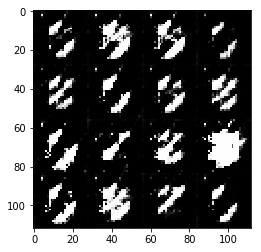

epoch 0 batch 320 Discriminator Loss: 0.1749 Generator Loss: 5.6775
epoch 0 batch 340 Discriminator Loss: 0.1590 Generator Loss: 3.5105
epoch 0 batch 360 Discriminator Loss: 0.9929 Generator Loss: 1.0090
epoch 0 batch 380 Discriminator Loss: 2.7424 Generator Loss: 0.4275
epoch 0 batch 400 Discriminator Loss: 0.3254 Generator Loss: 2.3767


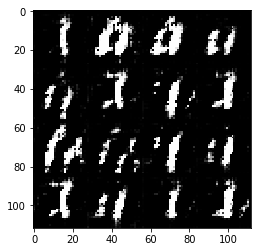

epoch 0 batch 420 Discriminator Loss: 0.3723 Generator Loss: 4.8208
epoch 0 batch 440 Discriminator Loss: 0.3494 Generator Loss: 4.8657
epoch 0 batch 460 Discriminator Loss: 1.1102 Generator Loss: 1.1158
epoch 0 batch 480 Discriminator Loss: 0.4994 Generator Loss: 2.7200
epoch 0 batch 500 Discriminator Loss: 1.0724 Generator Loss: 5.4905


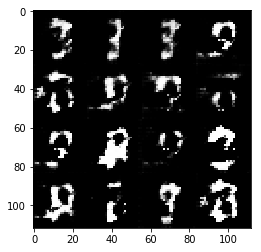

epoch 0 batch 520 Discriminator Loss: 0.5063 Generator Loss: 4.4545
epoch 0 batch 540 Discriminator Loss: 1.0868 Generator Loss: 0.7647
epoch 0 batch 560 Discriminator Loss: 0.3862 Generator Loss: 2.1186
epoch 0 batch 580 Discriminator Loss: 0.6806 Generator Loss: 1.3733
epoch 0 batch 600 Discriminator Loss: 0.8203 Generator Loss: 1.7795


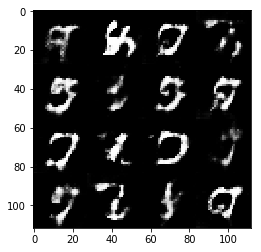

epoch 0 batch 620 Discriminator Loss: 0.8671 Generator Loss: 2.4245
epoch 0 batch 640 Discriminator Loss: 1.1114 Generator Loss: 2.9414
epoch 0 batch 660 Discriminator Loss: 0.7459 Generator Loss: 1.4798
epoch 0 batch 680 Discriminator Loss: 0.3792 Generator Loss: 2.1732
epoch 0 batch 700 Discriminator Loss: 0.7011 Generator Loss: 2.2520


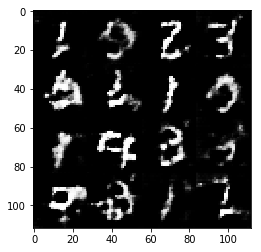

epoch 0 batch 720 Discriminator Loss: 0.8427 Generator Loss: 1.9443
epoch 0 batch 740 Discriminator Loss: 0.7255 Generator Loss: 2.9060
epoch 0 batch 760 Discriminator Loss: 0.7622 Generator Loss: 1.7116
epoch 0 batch 780 Discriminator Loss: 0.9684 Generator Loss: 2.1566
epoch 0 batch 800 Discriminator Loss: 0.9704 Generator Loss: 0.8323


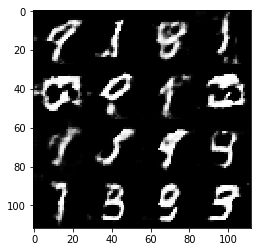

epoch 0 batch 820 Discriminator Loss: 0.7624 Generator Loss: 1.4973
epoch 0 batch 840 Discriminator Loss: 0.8010 Generator Loss: 2.3285
epoch 0 batch 860 Discriminator Loss: 0.7501 Generator Loss: 1.8928
epoch 0 batch 880 Discriminator Loss: 0.9205 Generator Loss: 1.2412
epoch 0 batch 900 Discriminator Loss: 1.0340 Generator Loss: 3.4222


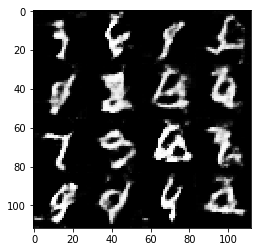

epoch 0 batch 920 Discriminator Loss: 0.9339 Generator Loss: 0.9912
epoch 1 batch 0 Discriminator Loss: 1.0721 Generator Loss: 2.3172


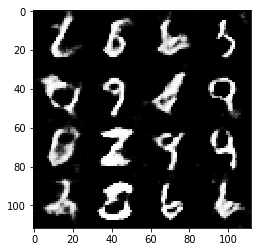

epoch 1 batch 20 Discriminator Loss: 1.1627 Generator Loss: 0.6501
epoch 1 batch 40 Discriminator Loss: 1.4818 Generator Loss: 0.4780
epoch 1 batch 60 Discriminator Loss: 1.8044 Generator Loss: 0.2369
epoch 1 batch 80 Discriminator Loss: 0.7785 Generator Loss: 1.7058
epoch 1 batch 100 Discriminator Loss: 0.8636 Generator Loss: 1.3768


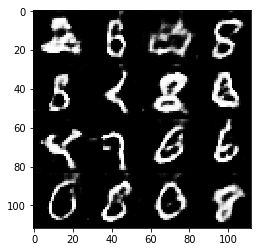

epoch 1 batch 120 Discriminator Loss: 1.4838 Generator Loss: 0.4238
epoch 1 batch 140 Discriminator Loss: 1.6362 Generator Loss: 3.6929
epoch 1 batch 160 Discriminator Loss: 0.9435 Generator Loss: 1.0471
epoch 1 batch 180 Discriminator Loss: 0.8328 Generator Loss: 0.8866
epoch 1 batch 200 Discriminator Loss: 1.0146 Generator Loss: 0.7592


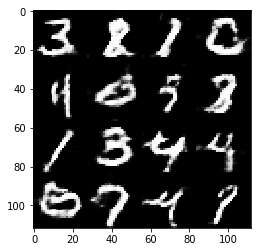

epoch 1 batch 220 Discriminator Loss: 1.1000 Generator Loss: 0.5431
epoch 1 batch 240 Discriminator Loss: 1.1237 Generator Loss: 0.5862
epoch 1 batch 260 Discriminator Loss: 1.5074 Generator Loss: 0.3544
epoch 1 batch 280 Discriminator Loss: 1.8483 Generator Loss: 2.8121
epoch 1 batch 300 Discriminator Loss: 0.9919 Generator Loss: 1.9076


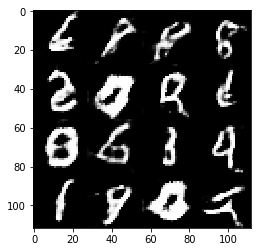

epoch 1 batch 320 Discriminator Loss: 1.1548 Generator Loss: 0.6059
epoch 1 batch 340 Discriminator Loss: 1.0870 Generator Loss: 0.6384
epoch 1 batch 360 Discriminator Loss: 1.0237 Generator Loss: 0.9095
epoch 1 batch 380 Discriminator Loss: 1.0172 Generator Loss: 0.7206
epoch 1 batch 400 Discriminator Loss: 0.9843 Generator Loss: 1.1440


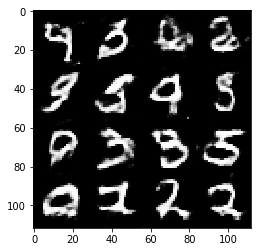

epoch 1 batch 420 Discriminator Loss: 0.9081 Generator Loss: 1.0945
epoch 1 batch 440 Discriminator Loss: 0.9059 Generator Loss: 1.1043
epoch 1 batch 460 Discriminator Loss: 1.0503 Generator Loss: 0.7254
epoch 1 batch 480 Discriminator Loss: 1.7496 Generator Loss: 0.3175
epoch 1 batch 500 Discriminator Loss: 0.7087 Generator Loss: 1.6430


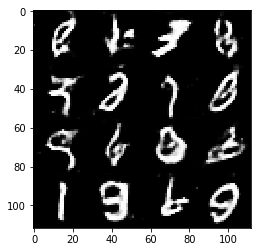

epoch 1 batch 520 Discriminator Loss: 1.1754 Generator Loss: 0.6380
epoch 1 batch 540 Discriminator Loss: 0.8978 Generator Loss: 0.8972
epoch 1 batch 560 Discriminator Loss: 1.6327 Generator Loss: 0.3287
epoch 1 batch 580 Discriminator Loss: 1.1378 Generator Loss: 0.6156
epoch 1 batch 600 Discriminator Loss: 0.8032 Generator Loss: 1.3549


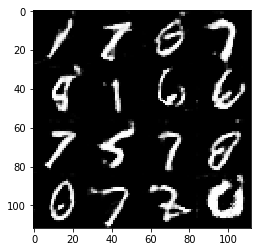

epoch 1 batch 620 Discriminator Loss: 1.1566 Generator Loss: 0.8183
epoch 1 batch 640 Discriminator Loss: 0.9052 Generator Loss: 1.0708
epoch 1 batch 660 Discriminator Loss: 1.0116 Generator Loss: 0.9929
epoch 1 batch 680 Discriminator Loss: 0.8987 Generator Loss: 0.9752
epoch 1 batch 700 Discriminator Loss: 1.3097 Generator Loss: 0.5345


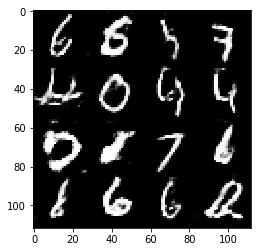

epoch 1 batch 720 Discriminator Loss: 1.1762 Generator Loss: 0.5809
epoch 1 batch 740 Discriminator Loss: 0.9445 Generator Loss: 1.2733
epoch 1 batch 760 Discriminator Loss: 1.3039 Generator Loss: 0.4978
epoch 1 batch 780 Discriminator Loss: 1.0519 Generator Loss: 1.0435
epoch 1 batch 800 Discriminator Loss: 1.1425 Generator Loss: 1.8353


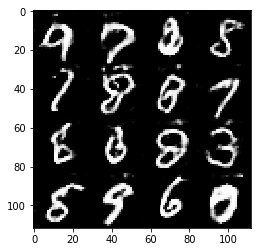

epoch 1 batch 820 Discriminator Loss: 1.0534 Generator Loss: 0.6568
epoch 1 batch 840 Discriminator Loss: 0.8429 Generator Loss: 1.2642
epoch 1 batch 860 Discriminator Loss: 1.6215 Generator Loss: 0.3255
epoch 1 batch 880 Discriminator Loss: 0.9311 Generator Loss: 1.0251
epoch 1 batch 900 Discriminator Loss: 1.2725 Generator Loss: 0.7120


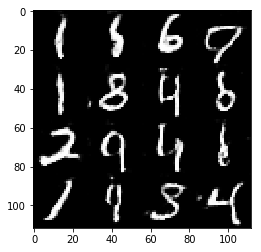

epoch 1 batch 920 Discriminator Loss: 1.0221 Generator Loss: 1.4400


In [124]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

epoch 0 batch 0 Discriminator Loss: 27.2425 Generator Loss: 0.0000


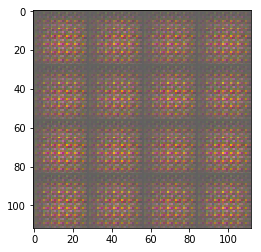

epoch 0 batch 20 Discriminator Loss: 2.9501 Generator Loss: 6.3578
epoch 0 batch 40 Discriminator Loss: 1.8310 Generator Loss: 0.5436
epoch 0 batch 60 Discriminator Loss: 0.1279 Generator Loss: 4.1518
epoch 0 batch 80 Discriminator Loss: 2.1291 Generator Loss: 0.5240
epoch 0 batch 100 Discriminator Loss: 0.5874 Generator Loss: 1.3339


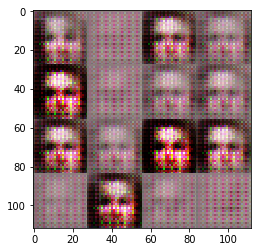

epoch 0 batch 120 Discriminator Loss: 0.1397 Generator Loss: 2.4760
epoch 0 batch 140 Discriminator Loss: 0.3921 Generator Loss: 1.9337
epoch 0 batch 160 Discriminator Loss: 2.2260 Generator Loss: 0.1511
epoch 0 batch 180 Discriminator Loss: 0.9440 Generator Loss: 0.7265
epoch 0 batch 200 Discriminator Loss: 0.0812 Generator Loss: 5.0585


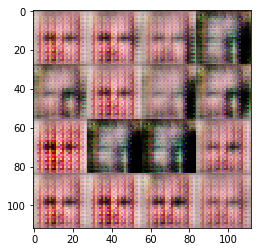

epoch 0 batch 220 Discriminator Loss: 0.6214 Generator Loss: 3.9830
epoch 0 batch 240 Discriminator Loss: 0.0881 Generator Loss: 5.0411
epoch 0 batch 260 Discriminator Loss: 0.1534 Generator Loss: 2.3487
epoch 0 batch 280 Discriminator Loss: 1.0929 Generator Loss: 0.6941
epoch 0 batch 300 Discriminator Loss: 0.8438 Generator Loss: 0.9363


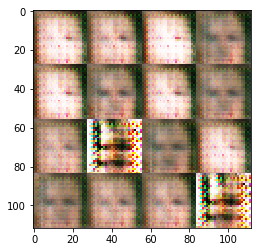

epoch 0 batch 320 Discriminator Loss: 0.8296 Generator Loss: 0.9814
epoch 0 batch 340 Discriminator Loss: 0.6021 Generator Loss: 1.1670
epoch 0 batch 360 Discriminator Loss: 0.4847 Generator Loss: 1.3341
epoch 0 batch 380 Discriminator Loss: 0.2848 Generator Loss: 2.5369
epoch 0 batch 400 Discriminator Loss: 0.4699 Generator Loss: 1.7122


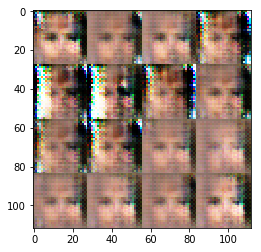

epoch 0 batch 420 Discriminator Loss: 0.1908 Generator Loss: 2.6127
epoch 0 batch 440 Discriminator Loss: 0.9047 Generator Loss: 0.9830
epoch 0 batch 460 Discriminator Loss: 0.9859 Generator Loss: 0.7509
epoch 0 batch 480 Discriminator Loss: 1.1709 Generator Loss: 0.7487
epoch 0 batch 500 Discriminator Loss: 0.6518 Generator Loss: 1.5322


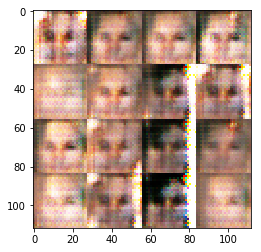

epoch 0 batch 520 Discriminator Loss: 0.8452 Generator Loss: 0.8297
epoch 0 batch 540 Discriminator Loss: 1.2343 Generator Loss: 0.9937
epoch 0 batch 560 Discriminator Loss: 0.9404 Generator Loss: 0.8779
epoch 0 batch 580 Discriminator Loss: 1.0246 Generator Loss: 1.3578
epoch 0 batch 600 Discriminator Loss: 1.3865 Generator Loss: 0.5588


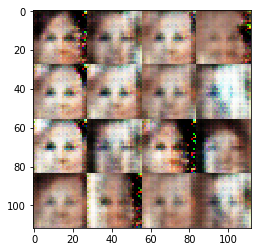

epoch 0 batch 620 Discriminator Loss: 0.8846 Generator Loss: 1.4797
epoch 0 batch 640 Discriminator Loss: 1.1794 Generator Loss: 1.1975
epoch 0 batch 660 Discriminator Loss: 1.3563 Generator Loss: 0.9662
epoch 0 batch 680 Discriminator Loss: 1.3799 Generator Loss: 0.7223
epoch 0 batch 700 Discriminator Loss: 0.7727 Generator Loss: 1.0184


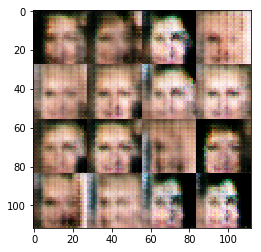

epoch 0 batch 720 Discriminator Loss: 0.8950 Generator Loss: 1.1280
epoch 0 batch 740 Discriminator Loss: 1.6390 Generator Loss: 0.4067
epoch 0 batch 760 Discriminator Loss: 0.9640 Generator Loss: 0.9437
epoch 0 batch 780 Discriminator Loss: 1.2793 Generator Loss: 0.7164
epoch 0 batch 800 Discriminator Loss: 1.0139 Generator Loss: 1.0929


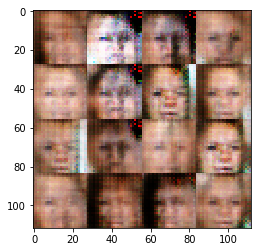

epoch 0 batch 820 Discriminator Loss: 1.1387 Generator Loss: 1.8343
epoch 0 batch 840 Discriminator Loss: 1.3304 Generator Loss: 0.6243
epoch 0 batch 860 Discriminator Loss: 1.0400 Generator Loss: 0.6903
epoch 0 batch 880 Discriminator Loss: 1.5538 Generator Loss: 0.4488
epoch 0 batch 900 Discriminator Loss: 1.6942 Generator Loss: 0.4181


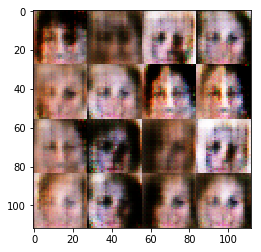

epoch 0 batch 920 Discriminator Loss: 0.7166 Generator Loss: 1.4909
epoch 0 batch 940 Discriminator Loss: 0.7526 Generator Loss: 1.2114
epoch 0 batch 960 Discriminator Loss: 0.7254 Generator Loss: 1.9447
epoch 0 batch 980 Discriminator Loss: 1.0006 Generator Loss: 0.6282
epoch 0 batch 1000 Discriminator Loss: 1.0997 Generator Loss: 1.6807


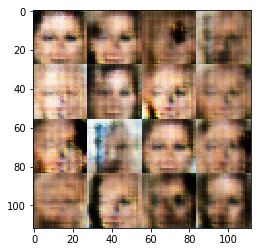

epoch 0 batch 1020 Discriminator Loss: 2.0602 Generator Loss: 3.6660
epoch 0 batch 1040 Discriminator Loss: 1.1584 Generator Loss: 0.5875
epoch 0 batch 1060 Discriminator Loss: 0.6930 Generator Loss: 1.1483
epoch 0 batch 1080 Discriminator Loss: 0.9257 Generator Loss: 0.9674
epoch 0 batch 1100 Discriminator Loss: 0.7388 Generator Loss: 1.2024


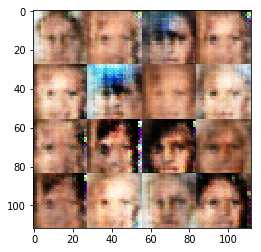

epoch 0 batch 1120 Discriminator Loss: 1.1415 Generator Loss: 0.8288
epoch 0 batch 1140 Discriminator Loss: 1.0250 Generator Loss: 0.8127
epoch 0 batch 1160 Discriminator Loss: 1.0696 Generator Loss: 1.1963
epoch 0 batch 1180 Discriminator Loss: 0.8652 Generator Loss: 1.1213
epoch 0 batch 1200 Discriminator Loss: 0.6471 Generator Loss: 1.1093


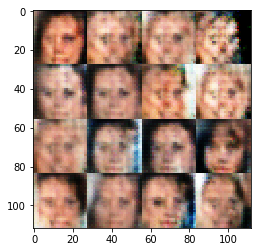

epoch 0 batch 1220 Discriminator Loss: 1.1100 Generator Loss: 0.8373
epoch 0 batch 1240 Discriminator Loss: 1.0929 Generator Loss: 1.4111
epoch 0 batch 1260 Discriminator Loss: 1.0600 Generator Loss: 0.6870
epoch 0 batch 1280 Discriminator Loss: 1.2076 Generator Loss: 1.1179
epoch 0 batch 1300 Discriminator Loss: 1.2730 Generator Loss: 0.5637


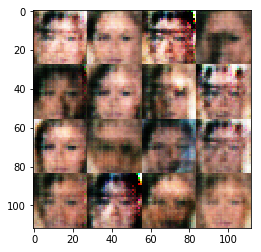

epoch 0 batch 1320 Discriminator Loss: 1.1023 Generator Loss: 0.7230
epoch 0 batch 1340 Discriminator Loss: 1.4799 Generator Loss: 1.5210
epoch 0 batch 1360 Discriminator Loss: 1.0948 Generator Loss: 1.1209
epoch 0 batch 1380 Discriminator Loss: 1.2128 Generator Loss: 0.6347
epoch 0 batch 1400 Discriminator Loss: 1.1633 Generator Loss: 0.7103


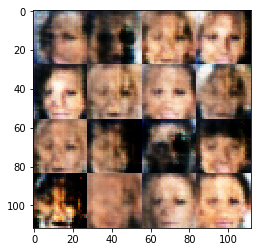

epoch 0 batch 1420 Discriminator Loss: 1.0602 Generator Loss: 1.1410
epoch 0 batch 1440 Discriminator Loss: 1.0689 Generator Loss: 0.7057
epoch 0 batch 1460 Discriminator Loss: 1.1220 Generator Loss: 0.7280
epoch 0 batch 1480 Discriminator Loss: 1.1241 Generator Loss: 0.7082
epoch 0 batch 1500 Discriminator Loss: 0.7673 Generator Loss: 1.2838


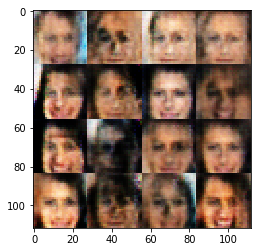

epoch 0 batch 1520 Discriminator Loss: 1.2479 Generator Loss: 0.6181
epoch 0 batch 1540 Discriminator Loss: 0.9514 Generator Loss: 1.3542
epoch 0 batch 1560 Discriminator Loss: 1.8975 Generator Loss: 0.2490
epoch 0 batch 1580 Discriminator Loss: 0.8183 Generator Loss: 1.7118
epoch 0 batch 1600 Discriminator Loss: 2.3714 Generator Loss: 3.7407


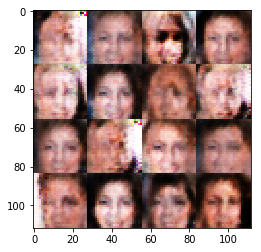

epoch 0 batch 1620 Discriminator Loss: 1.5125 Generator Loss: 1.6072
epoch 0 batch 1640 Discriminator Loss: 0.9126 Generator Loss: 1.1070
epoch 0 batch 1660 Discriminator Loss: 1.1815 Generator Loss: 0.8243
epoch 0 batch 1680 Discriminator Loss: 0.8973 Generator Loss: 0.9649
epoch 0 batch 1700 Discriminator Loss: 1.0951 Generator Loss: 0.8092


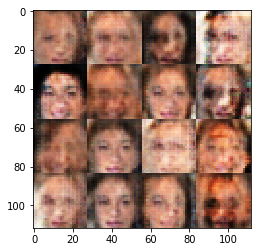

epoch 0 batch 1720 Discriminator Loss: 0.9128 Generator Loss: 1.1770
epoch 0 batch 1740 Discriminator Loss: 1.0382 Generator Loss: 0.9236
epoch 0 batch 1760 Discriminator Loss: 0.9073 Generator Loss: 0.9806
epoch 0 batch 1780 Discriminator Loss: 1.2692 Generator Loss: 0.8746
epoch 0 batch 1800 Discriminator Loss: 0.9585 Generator Loss: 1.2843


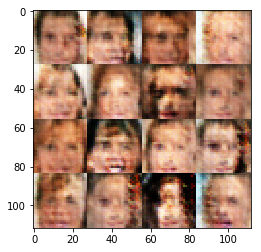

epoch 0 batch 1820 Discriminator Loss: 1.2926 Generator Loss: 1.4340
epoch 0 batch 1840 Discriminator Loss: 0.9131 Generator Loss: 1.0820
epoch 0 batch 1860 Discriminator Loss: 0.9929 Generator Loss: 0.9714
epoch 0 batch 1880 Discriminator Loss: 1.1087 Generator Loss: 1.2253
epoch 0 batch 1900 Discriminator Loss: 1.4713 Generator Loss: 0.4869


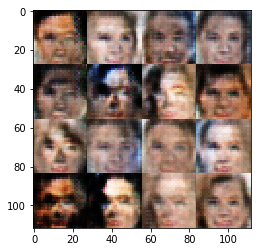

epoch 0 batch 1920 Discriminator Loss: 0.9526 Generator Loss: 2.0393
epoch 0 batch 1940 Discriminator Loss: 0.8176 Generator Loss: 1.1260
epoch 0 batch 1960 Discriminator Loss: 1.0802 Generator Loss: 1.1073
epoch 0 batch 1980 Discriminator Loss: 1.0231 Generator Loss: 1.0479
epoch 0 batch 2000 Discriminator Loss: 1.2834 Generator Loss: 0.5238


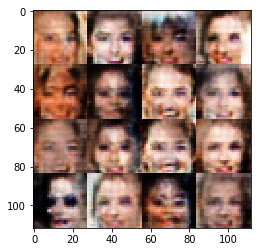

epoch 0 batch 2020 Discriminator Loss: 1.1075 Generator Loss: 1.1163
epoch 0 batch 2040 Discriminator Loss: 1.0613 Generator Loss: 0.7759
epoch 0 batch 2060 Discriminator Loss: 1.3839 Generator Loss: 0.4368
epoch 0 batch 2080 Discriminator Loss: 0.9096 Generator Loss: 1.2175
epoch 0 batch 2100 Discriminator Loss: 1.0501 Generator Loss: 1.3223


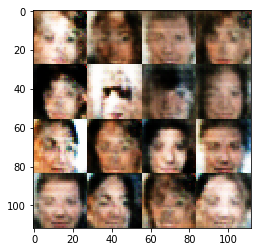

epoch 0 batch 2120 Discriminator Loss: 1.2400 Generator Loss: 0.5426
epoch 0 batch 2140 Discriminator Loss: 0.9852 Generator Loss: 0.7338
epoch 0 batch 2160 Discriminator Loss: 0.9906 Generator Loss: 1.2341
epoch 0 batch 2180 Discriminator Loss: 1.0846 Generator Loss: 1.7374
epoch 0 batch 2200 Discriminator Loss: 0.9575 Generator Loss: 1.0799


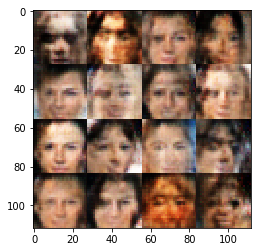

epoch 0 batch 2220 Discriminator Loss: 1.3003 Generator Loss: 1.1460
epoch 0 batch 2240 Discriminator Loss: 1.2999 Generator Loss: 0.7774
epoch 0 batch 2260 Discriminator Loss: 1.0423 Generator Loss: 0.8711
epoch 0 batch 2280 Discriminator Loss: 1.1451 Generator Loss: 1.4437
epoch 0 batch 2300 Discriminator Loss: 1.4513 Generator Loss: 2.1841


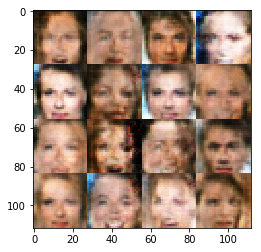

epoch 0 batch 2320 Discriminator Loss: 1.2913 Generator Loss: 1.7059
epoch 0 batch 2340 Discriminator Loss: 1.1602 Generator Loss: 0.6611
epoch 0 batch 2360 Discriminator Loss: 1.3085 Generator Loss: 0.4924
epoch 0 batch 2380 Discriminator Loss: 1.0796 Generator Loss: 1.3439
epoch 0 batch 2400 Discriminator Loss: 0.8323 Generator Loss: 1.8990


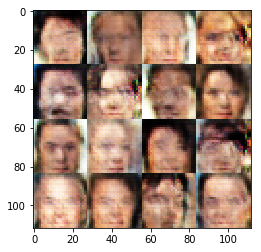

epoch 0 batch 2420 Discriminator Loss: 1.0437 Generator Loss: 0.9788
epoch 0 batch 2440 Discriminator Loss: 0.9318 Generator Loss: 0.8494
epoch 0 batch 2460 Discriminator Loss: 1.1266 Generator Loss: 0.9866
epoch 0 batch 2480 Discriminator Loss: 1.0749 Generator Loss: 1.4498
epoch 0 batch 2500 Discriminator Loss: 1.3062 Generator Loss: 0.9368


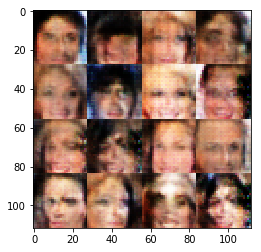

epoch 0 batch 2520 Discriminator Loss: 0.9645 Generator Loss: 0.8479
epoch 0 batch 2540 Discriminator Loss: 1.3007 Generator Loss: 0.6751
epoch 0 batch 2560 Discriminator Loss: 1.0671 Generator Loss: 1.0680
epoch 0 batch 2580 Discriminator Loss: 1.0037 Generator Loss: 1.9574
epoch 0 batch 2600 Discriminator Loss: 1.3939 Generator Loss: 1.5265


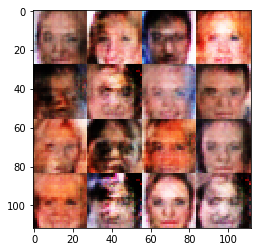

epoch 0 batch 2620 Discriminator Loss: 0.9213 Generator Loss: 1.1338
epoch 0 batch 2640 Discriminator Loss: 0.9163 Generator Loss: 1.0239
epoch 0 batch 2660 Discriminator Loss: 1.2241 Generator Loss: 0.6442
epoch 0 batch 2680 Discriminator Loss: 1.1179 Generator Loss: 0.7737
epoch 0 batch 2700 Discriminator Loss: 1.1590 Generator Loss: 0.8398


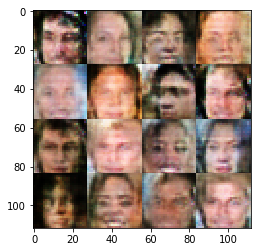

epoch 0 batch 2720 Discriminator Loss: 1.3081 Generator Loss: 0.4448
epoch 0 batch 2740 Discriminator Loss: 1.1203 Generator Loss: 1.0064
epoch 0 batch 2760 Discriminator Loss: 1.0861 Generator Loss: 1.2796
epoch 0 batch 2780 Discriminator Loss: 1.0871 Generator Loss: 1.1867
epoch 0 batch 2800 Discriminator Loss: 1.3604 Generator Loss: 1.5979


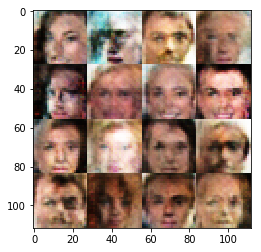

epoch 0 batch 2820 Discriminator Loss: 1.1136 Generator Loss: 0.8512
epoch 0 batch 2840 Discriminator Loss: 1.0366 Generator Loss: 0.8351
epoch 0 batch 2860 Discriminator Loss: 1.6981 Generator Loss: 0.2985
epoch 0 batch 2880 Discriminator Loss: 1.1515 Generator Loss: 1.2727
epoch 0 batch 2900 Discriminator Loss: 1.3791 Generator Loss: 0.3829


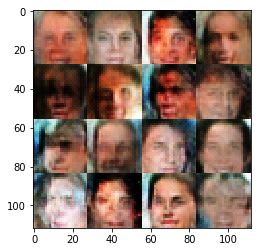

epoch 0 batch 2920 Discriminator Loss: 1.1063 Generator Loss: 1.0240
epoch 0 batch 2940 Discriminator Loss: 1.0003 Generator Loss: 1.2977
epoch 0 batch 2960 Discriminator Loss: 1.8110 Generator Loss: 0.3338
epoch 0 batch 2980 Discriminator Loss: 1.2319 Generator Loss: 0.8575
epoch 0 batch 3000 Discriminator Loss: 1.1271 Generator Loss: 1.2604


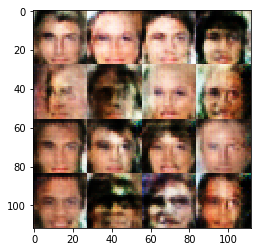

epoch 0 batch 3020 Discriminator Loss: 1.0356 Generator Loss: 0.8234
epoch 0 batch 3040 Discriminator Loss: 1.1457 Generator Loss: 1.3065
epoch 0 batch 3060 Discriminator Loss: 0.8885 Generator Loss: 1.1058
epoch 0 batch 3080 Discriminator Loss: 1.2079 Generator Loss: 0.8374
epoch 0 batch 3100 Discriminator Loss: 0.9672 Generator Loss: 1.4296


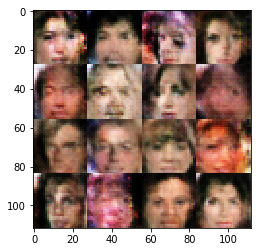

epoch 0 batch 3120 Discriminator Loss: 1.1308 Generator Loss: 0.7767
epoch 0 batch 3140 Discriminator Loss: 1.0836 Generator Loss: 0.7171
epoch 0 batch 3160 Discriminator Loss: 1.1678 Generator Loss: 0.6681


In [127]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.